let's copy over the `read_gadget.py` contents and run it:

In [1]:
import yt

ds = yt.load_sample("snapshot_033")

reg = ds.all_data()

class MockSelector:
    is_all_data = True

class MockChunkObject:
    def __init__(self, data_file):
        self.data_files = [data_file]

class MockChunk:
    def __init__(self, data_file):
        self.objs = [MockChunkObject(data_file)]

ptf = {'PartType0': ['Coordinates']}

chunks = [MockChunk(data_file) for data_file in ds.index.data_files]
selector= MockSelector()

my_gen = ds.index.io._read_particle_fields(chunks, ptf, selector)
my_result = [_ for _ in my_gen]


yt : [WARNING  ] 2020-09-11 16:38:38,643 tqdm is not installed, progress bar can not be displayed.
yt : [INFO     ] 2020-09-11 16:38:39,162 Files located at /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.
yt : [INFO     ] 2020-09-11 16:38:39,163 Default to loading snap_033.0.hdf5 for snapshot_033 dataset
yt : [INFO     ] 2020-09-11 16:38:39,219 Parameters: current_time              = 4.343952725460923e+17 s
yt : [INFO     ] 2020-09-11 16:38:39,219 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2020-09-11 16:38:39,220 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-09-11 16:38:39,220 Parameters: domain_right_edge         = [25. 25. 25.]
yt : [INFO     ] 2020-09-11 16:38:39,221 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-09-11 16:38:39,221 Parameters: current_redshift          = -4.811891664902035e-05
yt : [INFO     ] 2020-09-11 16:38:39,222 Parameters: omega_lambda              

So what comes out of this is a list with an entry for each chunk: 

In [2]:
my_result[0]

(('PartType0', 'Coordinates'),
 array([[ 7.6320577 , 11.81454   ,  0.5112596 ],
        [ 7.630863  , 11.814384  ,  0.51114064],
        [ 7.633304  , 11.81966   ,  0.51152855],
        ...,
        [ 9.0948305 , 18.531418  , 13.523693  ],
        [ 9.084332  , 18.547832  , 13.502992  ],
        [ 9.102446  , 18.544275  , 13.524328  ]], dtype=float32))

the `ds.index.data_files` objects is a list of `ParticleFile` objects with info about how that chunk including the on-disc datafile and start/end indices within that datafile:

In [3]:
for fid in [0,1,2]:
    print(ds.index.data_files[fid].filename)
    print([ds.index.data_files[fid].start,ds.index.data_files[fid].end])

/home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.0.hdf5
[0, 262144]
/home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.0.hdf5
[262144, 280105]
/home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.1.hdf5
[0, 262144]


Several ideas for applying dask:

* parrallelize: some dask.delayed() decorating to parallelize without relying on MPI
* daskify the read_particle_fields function to return dask arrays? 

Let's try writing a `read_particle_fields` that we can mess with by copying the `gadget` one: 

In [4]:
type(ds.index.io)

yt.frontends.gadget.io.IOHandlerGadgetHDF5

In [5]:
import h5py
def read_particle_fields(self,chunks, ptf, selector):
        # Now we have all the sizes, and we can allocate
        data_files = set([])
        for chunk in chunks:
            for obj in chunk.objs:
                data_files.update(obj.data_files)
                fls=','.join([x.filename for x in obj.data_files])
                print(f'adding {fls}')
                
        for data_file in sorted(data_files, key=lambda x: (x.filename, x.start)):
            si, ei = data_file.start, data_file.end
            f = h5py.File(data_file.filename, mode="r")
            for ptype, field_list in sorted(ptf.items()):
                if data_file.total_particles[ptype] == 0:
                    continue
                g = f[f"/{ptype}"]
                if getattr(selector, "is_all_data", False):
                    mask = slice(None, None, None)
                    mask_sum = data_file.total_particles[ptype]
                    hsmls = None
                else:
                    coords = g["Coordinates"][si:ei].astype("float64")
                    if ptype == "PartType0":
                        hsmls = self._get_smoothing_length(
                            data_file, g["Coordinates"].dtype, g["Coordinates"].shape
                        ).astype("float64")
                    else:
                        hsmls = 0.0
                    mask = selector.select_points(
                        coords[:, 0], coords[:, 1], coords[:, 2], hsmls
                    )
                    if mask is not None:
                        mask_sum = mask.sum()
                    del coords
                if mask is None:
                    continue
                for field in field_list:
                    if field in ("Mass", "Masses") and ptype not in self.var_mass:
                        data = np.empty(mask_sum, dtype="float64")
                        ind = self._known_ptypes.index(ptype)
                        data[:] = self.ds["Massarr"][ind]
                    elif field in self._element_names:
                        rfield = "ElementAbundance/" + field
                        data = g[rfield][si:ei][mask, ...]
                    elif field.startswith("Metallicity_"):
                        col = int(field.rsplit("_", 1)[-1])
                        data = g["Metallicity"][si:ei, col][mask]
                    elif field.startswith("GFM_Metals_"):
                        col = int(field.rsplit("_", 1)[-1])
                        data = g["GFM_Metals"][si:ei, col][mask]
                    elif field.startswith("Chemistry_"):
                        col = int(field.rsplit("_", 1)[-1])
                        data = g["ChemistryAbundances"][si:ei, col][mask]
                    elif field == "smoothing_length":
                        # This is for frontends which do not store
                        # the smoothing length on-disk, so we do not
                        # attempt to read them, but instead assume
                        # that they are calculated in _get_smoothing_length.
                        if hsmls is None:
                            hsmls = self._get_smoothing_length(
                                data_file,
                                g["Coordinates"].dtype,
                                g["Coordinates"].shape,
                            ).astype("float64")
                        data = hsmls[mask]
                    else:
                        data = g[field][si:ei][mask, ...]

                    yield (ptype, field), data
            f.close()

and now call the new one, passing in the `ds.index.io` object as `self`: 

In [6]:
# my_gen = ds.index.io._read_particle_fields(chunks, ptf, selector)
my_gen = read_particle_fields(ds.index.io, chunks, ptf, selector)
my_result = [_ for _ in my_gen]
my_result[:3]

adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.0.hdf5
adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.0.hdf5
adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.1.hdf5
adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.1.hdf5
adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.2.hdf5
adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.2.hdf5
adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.3.hdf5
adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.3.hdf5
adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.4.hdf5
adding /home/chavlin/hdd/dat

[(('PartType0', 'Coordinates'),
  array([[ 7.6320577 , 11.81454   ,  0.5112596 ],
         [ 7.630863  , 11.814384  ,  0.51114064],
         [ 7.633304  , 11.81966   ,  0.51152855],
         ...,
         [ 9.0948305 , 18.531418  , 13.523693  ],
         [ 9.084332  , 18.547832  , 13.502992  ],
         [ 9.102446  , 18.544275  , 13.524328  ]], dtype=float32)),
 (('PartType0', 'Coordinates'),
  array([[ 9.0948925, 18.540127 , 13.505761 ],
         [ 9.099401 , 18.551332 , 13.511906 ],
         [ 9.082766 , 18.54066  , 13.496419 ],
         ...,
         [ 9.948605 ,  8.47677  , 14.566635 ],
         [ 9.948661 ,  8.478258 , 14.567051 ],
         [ 9.94791  ,  8.478077 , 14.566901 ]], dtype=float32)),
 (('PartType0', 'Coordinates'),
  array([[ 1.5066416 ,  0.0244492 ,  3.2759523 ],
         [ 1.5392694 ,  0.05701507,  3.292754  ],
         [ 1.5390531 ,  0.05318429,  3.30687   ],
         ...,
         [11.684051  , 10.220002  , 19.18336   ],
         [11.671257  , 10.222958  , 19.17415

huh, that actually worked. cool. let's explore some ways to use dask here.... start with loading the data into dask as soon as it's read from disk. let's try to return the data for each chunk as sub-chunked dask arrays. To do that we'll need to read the data from disk into a dask array...

In [7]:
ds.index.data_files[0].filename

'/home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.0.hdf5'

Does dask's read_hdf work here?
```
dask.dataframe.read_hdf(pattern, key, start=0, stop=None, columns=None, chunksize=1000000, sorted_index=False, lock=True, mode='a')
```

In [8]:
from dask import dataframe as df, array as da

turns out it won't work: likely a pandas hdf issue -- seems there's a common issue (e.g. [this](https://github.com/dask/dask/issues/747)) in which pandas can only read very specific hdf files.... so this errors:


```
gkey = "/PartType0"
df.read_hdf(ds.index.data_files[0].filename,gkey,mode='r')
```

`TypeError: cannot create a storer if the object is not existing nor a value are passed`


but we can try reading with h5py and loading as a dask array following https://docs.dask.org/en/latest/array-creation.html#numpy-slicing

In [9]:
f = h5py.File(ds.index.data_files[0].filename, mode="r")

In [10]:
gkey = "/PartType0"
coords = f[gkey]['Coordinates'][ds.index.data_files[0].start:ds.index.data_files[0].end].astype("float64")
coords.shape

(262144, 3)

In [11]:
coords_da = da.from_array(coords, chunks=(30000, 1))
coords_da

dask.array<array, shape=(262144, 3), dtype=float64, chunksize=(30000, 1), chunktype=numpy.ndarray>

So that would be a sub-chunk of a single base chunk (the base chunk == the file with the start/end indeces, here we're splitting that up). The above dask docs link claims "This process is entirely lazy. Neither creating the h5py object nor wrapping it with da.from_array have loaded any data." hmm... but `coords` here should be in memory? confused... in any case:

Let's assemble a delayed dask list of sub-chunked chunks? 

First let's write a new read function to return dask arrays?

In [12]:
def read_particle_fields_dask(self,chunks, ptf, selector):
    
        # let's still loop over the chunks 
        data_files = set([])
        for chunk in chunks:
            for obj in chunk.objs:
                data_files.update(obj.data_files)
                fls=','.join([x.filename for x in obj.data_files])
                print(f'adding {fls}')
                
        # and we still loop over each base chunk  
        for data_file in sorted(data_files, key=lambda x: (x.filename, x.start)):
            si, ei = data_file.start, data_file.end
            f = h5py.File(data_file.filename, mode="r")
            
            for ptype, field_list in sorted(ptf.items()):
                if data_file.total_particles[ptype] == 0:
                    continue
                g = f[f"/{ptype}"]
                if getattr(selector, "is_all_data", False):
                    mask = slice(None, None, None)
                    mask_sum = data_file.total_particles[ptype]
                    hsmls = None
                else:
                    coords = g["Coordinates"][si:ei].astype("float64")
                    if ptype == "PartType0":
                        hsmls = self._get_smoothing_length(
                            data_file, g["Coordinates"].dtype, g["Coordinates"].shape
                        ).astype("float64")
                    else:
                        hsmls = 0.0
                    mask = selector.select_points(
                        coords[:, 0], coords[:, 1], coords[:, 2], hsmls
                    )
                    if mask is not None:
                        mask_sum = mask.sum()
                    del coords
                if mask is None:
                    continue
                for field in field_list:
                    if field in ("Mass", "Masses") and ptype not in self.var_mass:
                        data = np.empty(mask_sum, dtype="float64")
                        ind = self._known_ptypes.index(ptype)
                        data[:] = self.ds["Massarr"][ind]
                    elif field in self._element_names:
                        rfield = "ElementAbundance/" + field
                        data = g[rfield][si:ei][mask, ...]
                    elif field.startswith("Metallicity_"):
                        col = int(field.rsplit("_", 1)[-1])
                        data = g["Metallicity"][si:ei, col][mask]
                    elif field.startswith("GFM_Metals_"):
                        col = int(field.rsplit("_", 1)[-1])
                        data = g["GFM_Metals"][si:ei, col][mask]
                    elif field.startswith("Chemistry_"):
                        col = int(field.rsplit("_", 1)[-1])
                        data = g["ChemistryAbundances"][si:ei, col][mask]
                    elif field == "smoothing_length":
                        # This is for frontends which do not store
                        # the smoothing length on-disk, so we do not
                        # attempt to read them, but instead assume
                        # that they are calculated in _get_smoothing_length.
                        if hsmls is None:
                            hsmls = self._get_smoothing_length(
                                data_file,
                                g["Coordinates"].dtype,
                                g["Coordinates"].shape,
                            ).astype("float64")
                        data = hsmls[mask]
                    else:
                        data = g[field][si:ei][mask, ...]

                  
                    if data.ndim > 1:
                        subchunk_shape = (10000,1)  # dont chunk up multidim arrays like Coordinates
                    else:
                        subchunk_shape = (10000)  
                        
                    yield (ptype, field), da.from_array(data,chunks=subchunk_shape)
            f.close()

In [13]:
my_gen = read_particle_fields_dask(ds.index.io, chunks, ptf, selector)
my_result = [_ for _ in my_gen]


adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.0.hdf5
adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.0.hdf5
adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.1.hdf5
adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.1.hdf5
adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.2.hdf5
adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.2.hdf5
adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.3.hdf5
adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.3.hdf5
adding /home/chavlin/hdd/data/yt_data/yt_sample_sets/snapshot_033.tar.gz.untar/snapshot_033/snap_033.4.hdf5
adding /home/chavlin/hdd/dat

now each of those data chunks is a dask array:

In [14]:
type(my_result[0][1])

dask.array.core.Array

In [15]:
my_result[0][1]

dask.array<array, shape=(262144, 3), dtype=>f4, chunksize=(10000, 1), chunktype=numpy.ndarray>

In [16]:
my_result[:10]

[(('PartType0', 'Coordinates'),
  dask.array<array, shape=(262144, 3), dtype=>f4, chunksize=(10000, 1), chunktype=numpy.ndarray>),
 (('PartType0', 'Coordinates'),
  dask.array<array, shape=(419, 3), dtype=>f4, chunksize=(419, 1), chunktype=numpy.ndarray>),
 (('PartType0', 'Coordinates'),
  dask.array<array, shape=(255819, 3), dtype=>f4, chunksize=(10000, 1), chunktype=numpy.ndarray>),
 (('PartType0', 'Coordinates'),
  dask.array<array, shape=(251598, 3), dtype=>f4, chunksize=(10000, 1), chunktype=numpy.ndarray>),
 (('PartType0', 'Coordinates'),
  dask.array<array, shape=(244445, 3), dtype=>f4, chunksize=(10000, 1), chunktype=numpy.ndarray>),
 (('PartType0', 'Coordinates'),
  dask.array<array, shape=(239908, 3), dtype=>f4, chunksize=(10000, 1), chunktype=numpy.ndarray>),
 (('PartType0', 'Coordinates'),
  dask.array<array, shape=(233206, 3), dtype=>f4, chunksize=(10000, 1), chunktype=numpy.ndarray>),
 (('PartType0', 'Coordinates'),
  dask.array<array, shape=(227868, 3), dtype=>f4, chunks

In [17]:
my_result[0][1][:10,:]

dask.array<getitem, shape=(10, 3), dtype=>f4, chunksize=(10, 1), chunktype=numpy.ndarray>

In [18]:
my_result[0][1][:10,:].compute()

array([[ 7.6320577 , 11.81454   ,  0.5112596 ],
       [ 7.630863  , 11.814384  ,  0.51114064],
       [ 7.633304  , 11.81966   ,  0.51152855],
       [ 7.6330523 , 11.819399  ,  0.51174545],
       [ 7.6328063 , 11.818984  ,  0.512373  ],
       [ 7.634123  , 11.820499  ,  0.5114557 ],
       [ 7.6352324 , 11.820305  ,  0.5110059 ],
       [ 7.634844  , 11.817485  ,  0.5118982 ],
       [ 7.6348486 , 11.817831  ,  0.51274544],
       [ 7.635442  , 11.818255  ,  0.5099228 ]], dtype=float32)

Ok, so then let's try using dask to compute a derived quantity in parallel? Let's find a mean? One chunk would be:

In [19]:
my_result[0][1].mean().compute()

12.328807

In [20]:
my_result[0][1].size

786432

so not in parallel, we could do:

In [21]:
meanval=0.
count=0. 
for result in my_result:
    count+=result[1].size
    meanval+=result[1].sum().compute()
meanval=meanval / count 
print(meanval)

12.217880717413463


to parallelize, we can assemble some dask delayed tasks and compute them after initializing a dask.distributed Client:

In [22]:
from dask import delayed,compute


sums = [] 
count=0. 
for result in my_result:
    count+=result[1].size
    sums.append(delayed(result[1].sum()))
    
sums

[Delayed('Array-e41adb70-2da0-433c-9718-479881dfc87c'),
 Delayed('Array-0143d16e-d445-4464-941b-1b2bac2eac1c'),
 Delayed('Array-8e74d8e7-9ccd-49d8-9529-52a14aa96380'),
 Delayed('Array-beefeaa5-24bf-4b22-82b1-ccc1b0bf46dd'),
 Delayed('Array-040edded-40e9-46ef-b5ba-60dbc357c6ec'),
 Delayed('Array-e84304f4-7376-498f-86c6-9bbe024113fb'),
 Delayed('Array-3b8d33d5-5acd-478b-9ae2-4e8a978472f1'),
 Delayed('Array-954580ab-7998-4099-aab6-4f8c94064677'),
 Delayed('Array-e6c8498b-b55e-4df6-917f-e104e8e0a0cd')]

In [23]:
from dask.distributed import Client 
c = Client(threads_per_worker=1,n_workers=4)

In [24]:
import numpy as np
summed = np.sum(compute(*sums))/count

In [25]:
summed

12.21788017812798

In [26]:
def findmin(chunks):
    
    # assemble the delayed operation 
    minvals = []
    for result in my_result:
        minvals.append(delayed(result[1].min()))

    # return the min of each 
    return np.min(compute(*minvals))
    

In [27]:
findmin(my_result)

0.0

a trival example, but it seems to work. the minval of each chunk is calculated on separate processors and we compute the min over all the chunks after using `compute` to collect. 

## An aside about units 

Let's check what happens to a yt array when stored as a dask array

In [28]:
import yt

In [29]:
dasked_yt = da.from_array(yt.YTArray(np.random.random(10000),'kpc'),chunks=(1000,))
dasked_yt

dask.array<array, shape=(10000,), dtype=float64, chunksize=(1000,), chunktype=unyt.unyt_array>

In [30]:
dasked_yt.mean().compute()

0.5024082279261486

so things work, but we lose the `unyt` attachment

In [31]:
yt.YTArray(np.random.random(10000),'kpc').mean()

unyt_quantity(0.49938446, 'kpc')

## back to loading

so if we use dask delayed, we don't need the generator at all. something simpler like:

In [32]:
def load_single_chunk(self,data_file,ptf,selector):
    si, ei = data_file.start, data_file.end
    f = h5py.File(data_file.filename, mode="r")
    chunk_data = []
    for ptype, field_list in sorted(ptf.items()):
        if data_file.total_particles[ptype] == 0:
            continue
        g = f[f"/{ptype}"]
        if getattr(selector, "is_all_data", False):
            mask = slice(None, None, None)
            mask_sum = data_file.total_particles[ptype]
            hsmls = None
        else:
            coords = g["Coordinates"][si:ei].astype("float64")
            if ptype == "PartType0":
                hsmls = self._get_smoothing_length(
                    data_file, g["Coordinates"].dtype, g["Coordinates"].shape
                ).astype("float64")
            else:
                hsmls = 0.0
            mask = selector.select_points(
                coords[:, 0], coords[:, 1], coords[:, 2], hsmls
            )
            if mask is not None:
                mask_sum = mask.sum()
            del coords
        if mask is None:
            continue
        for field in field_list:
            if field in ("Mass", "Masses") and ptype not in self.var_mass:
                data = np.empty(mask_sum, dtype="float64")
                ind = self._known_ptypes.index(ptype)
                data[:] = self.ds["Massarr"][ind]
            elif field in self._element_names:
                rfield = "ElementAbundance/" + field
                data = g[rfield][si:ei][mask, ...]
            elif field.startswith("Metallicity_"):
                col = int(field.rsplit("_", 1)[-1])
                data = g["Metallicity"][si:ei, col][mask]
            elif field.startswith("GFM_Metals_"):
                col = int(field.rsplit("_", 1)[-1])
                data = g["GFM_Metals"][si:ei, col][mask]
            elif field.startswith("Chemistry_"):
                col = int(field.rsplit("_", 1)[-1])
                data = g["ChemistryAbundances"][si:ei, col][mask]
            elif field == "smoothing_length":
                # This is for frontends which do not store
                # the smoothing length on-disk, so we do not
                # attempt to read them, but instead assume
                # that they are calculated in _get_smoothing_length.
                if hsmls is None:
                    hsmls = self._get_smoothing_length(
                        data_file,
                        g["Coordinates"].dtype,
                        g["Coordinates"].shape,
                    ).astype("float64")
                data = hsmls[mask]
            else:
                data = g[field][si:ei][mask, ...]


            if data.ndim > 1:
                subchunk_shape = (10000,1)  # dont chunk up multidim arrays like Coordinates
            else:
                subchunk_shape = (10000)  

            chunk_data.append([(ptype, field), delayed(da.from_array(data,chunks=subchunk_shape))])
    f.close()
    return chunk_data 
    
def read_particle_fields_delayed(self,chunks, ptf, selector):
    
        # let's still loop over the chunks 
        data_files = set([])
        for chunk in chunks:
            for obj in chunk.objs:
                data_files.update(obj.data_files)
                
        # and we still loop over each base chunk  
        all_chunks=[]
        for data_file in sorted(data_files, key=lambda x: (x.filename, x.start)):
            ch = load_single_chunk(self,data_file,ptf,selector)
            if len(ch)>0:
                all_chunks.append(ch)
        
        return all_chunks 

In [33]:
my_gen_delay = read_particle_fields_delayed(ds.index.io, chunks, ptf, selector)

In [34]:
my_gen_delay[0]

[[('PartType0', 'Coordinates'),
  Delayed('Array-a2a94919-bac7-404c-abd1-fce2b7534342')]]

cool, now our dask arrays are delayed! and to pull in one array:

In [35]:
chunk_1 = compute(my_gen_delay[0][0][1])
chunk_1 

(array([[ 7.6320577 , 11.81454   ,  0.5112596 ],
        [ 7.630863  , 11.814384  ,  0.51114064],
        [ 7.633304  , 11.81966   ,  0.51152855],
        ...,
        [ 9.0948305 , 18.531418  , 13.523693  ],
        [ 9.084332  , 18.547832  , 13.502992  ],
        [ 9.102446  , 18.544275  , 13.524328  ]], dtype=float32),)

hmm, but that's not easy to send off to the client. would have to loop through?

In [36]:
assembled_chunks = [ch[0][1] for ch in my_gen_delay] 
assembled_chunks

[Delayed('Array-a2a94919-bac7-404c-abd1-fce2b7534342'),
 Delayed('Array-264ec241-f844-4ab4-8aec-080fba0bb0cc'),
 Delayed('Array-14f1c726-f7d5-466e-954f-fc66f1747c3b'),
 Delayed('Array-4c3adc40-aede-4e7b-ab87-81008e9a4dda'),
 Delayed('Array-49b7e695-2316-48ea-bde5-4d8f306e192a'),
 Delayed('Array-09c0de47-90fd-4f09-98bd-9fdfcab27ce4'),
 Delayed('Array-70ecce11-502f-474d-b79f-c73b4c68a6b6'),
 Delayed('Array-b13fa60c-9015-4784-81ad-381679bab024'),
 Delayed('Array-a8870bea-bd66-4f6c-93c8-b73b1c4a2414')]

In [37]:
computed_chunks = compute(*assembled_chunks)
computed_chunks

(array([[ 7.6320577 , 11.81454   ,  0.5112596 ],
        [ 7.630863  , 11.814384  ,  0.51114064],
        [ 7.633304  , 11.81966   ,  0.51152855],
        ...,
        [ 9.0948305 , 18.531418  , 13.523693  ],
        [ 9.084332  , 18.547832  , 13.502992  ],
        [ 9.102446  , 18.544275  , 13.524328  ]], dtype=float32),
 array([[ 9.0948925, 18.540127 , 13.505761 ],
        [ 9.099401 , 18.551332 , 13.511906 ],
        [ 9.082766 , 18.54066  , 13.496419 ],
        ...,
        [ 9.948605 ,  8.47677  , 14.566635 ],
        [ 9.948661 ,  8.478258 , 14.567051 ],
        [ 9.94791  ,  8.478077 , 14.566901 ]], dtype=float32),
 array([[ 1.5066416 ,  0.0244492 ,  3.2759523 ],
        [ 1.5392694 ,  0.05701507,  3.292754  ],
        [ 1.5390531 ,  0.05318429,  3.30687   ],
        ...,
        [11.684051  , 10.220002  , 19.18336   ],
        [11.671257  , 10.222958  , 19.174152  ],
        [11.676265  , 10.222806  , 19.190056  ]], dtype=float32),
 array([[ 9.324989, 11.688595,  9.788749],
   

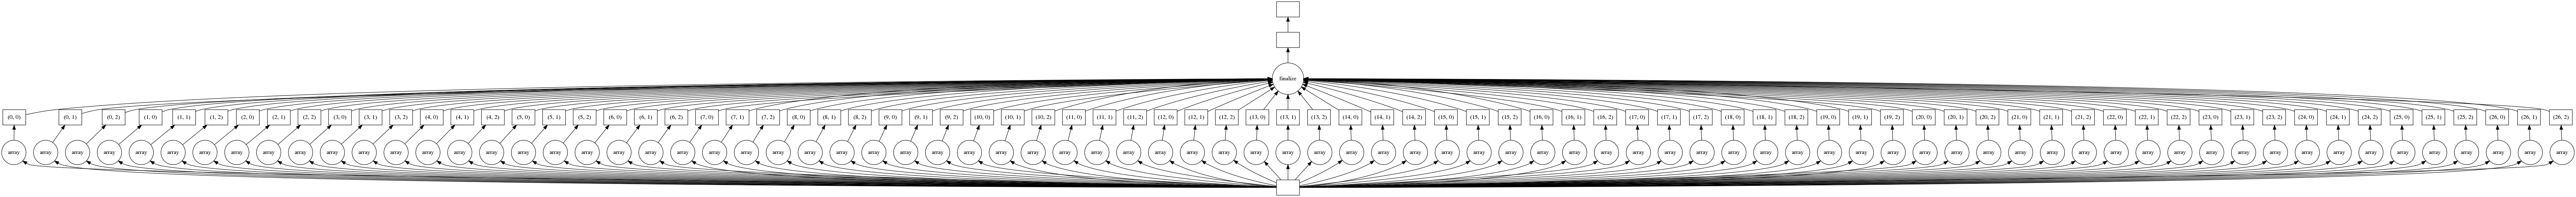

In [38]:
assembled_chunks[0].visualize()

what about this selector?

my_gen_delay = read_particle_fields_delayed(ds.index.io, chunks, ptf, selector)

In [39]:
ds.domain_right_edge

unyt_array([25., 25., 25.], 'code_length')

sp1 = self.ds.sphere("c", (0.1, "unitary"))
        self.compare_dobj_selection(sp1)
    
    sel_index = sp1.selector.select_points(x, y, z, radii)

In [40]:
sp = ds.sphere(ds.domain_center,(2,'code_length'))

In [41]:
sp.selector

In [42]:
my_gen_delay = read_particle_fields_delayed(ds.index.io, chunks, ptf, sp.selector)

In [43]:
my_gen_delay

[[[('PartType0', 'Coordinates'),
   Delayed('Array-ffc73231-85cf-47c6-8aa4-6493ec127300')]],
 [[('PartType0', 'Coordinates'),
   Delayed('Array-3c918dc4-a669-4eed-a8bc-10e411d692ef')]],
 [[('PartType0', 'Coordinates'),
   Delayed('Array-5e0405e4-ef25-4e09-8602-af38be62c9be')]],
 [[('PartType0', 'Coordinates'),
   Delayed('Array-25f68b5b-da72-468b-961a-a35c51b5d70e')]],
 [[('PartType0', 'Coordinates'),
   Delayed('Array-b2c54a76-6e6a-47b8-9a1a-7b4a2af7ccda')]],
 [[('PartType0', 'Coordinates'),
   Delayed('Array-964b409e-14c5-480e-bce0-cf1eca09270b')]],
 [[('PartType0', 'Coordinates'),
   Delayed('Array-fd6148b5-8217-400e-bc15-4a894121bee1')]],
 [[('PartType0', 'Coordinates'),
   Delayed('Array-f6a8902e-8110-4181-ac9d-795f86fac57f')]]]

In [44]:
computed_chunks = compute(*[ch[0][1] for ch in my_gen_delay])

In [45]:
computed_chunks

(array([[13.289266, 11.24863 , 12.798835],
        [13.301256, 11.25296 , 12.7941  ],
        [13.289645, 11.23968 , 12.841264],
        ...,
        [13.476827, 11.077276, 12.637663],
        [13.450735, 11.045864, 12.608513],
        [13.465006, 11.054926, 12.644259]], dtype=float32),
 array([[13.438538, 11.043177, 12.576794],
        [13.438513, 11.05965 , 12.594496],
        [13.477322, 11.074251, 12.567007],
        ...,
        [13.389408, 11.19235 , 12.925274],
        [13.389811, 11.192268, 12.92547 ],
        [13.389717, 11.191995, 12.925444]], dtype=float32),
 array([[12.577198 , 10.984266 , 10.982687 ],
        [12.504118 , 11.027195 , 11.000502 ],
        [12.574895 , 10.9623   , 11.124585 ],
        ...,
        [13.414405 , 11.160495 , 12.9049635],
        [13.421838 , 11.174578 , 12.896686 ],
        [13.404836 , 11.170236 , 12.899614 ]], dtype=float32),
 array([[13.430939, 11.190566, 12.990604],
        [13.436688, 11.182026, 13.001401],
        [13.445953, 11.196572, 1

In [46]:
ds.domain_center

unyt_array([12.5, 12.5, 12.5], 'code_length')

hmm... why are there coords more than > 12.75? 

in any case, the delay should wrap the whole chunk, including sphere filtering i think: 

In [47]:
def load_single_chunk(self,data_file,ptf,selector):
    si, ei = data_file.start, data_file.end
    f = h5py.File(data_file.filename, mode="r")
    chunk_data = []
    for ptype, field_list in sorted(ptf.items()):
        if data_file.total_particles[ptype] == 0:
            continue
        g = f[f"/{ptype}"]
        if getattr(selector, "is_all_data", False):
            mask = slice(None, None, None)
            mask_sum = data_file.total_particles[ptype]
            hsmls = None
        else:
            coords = g["Coordinates"][si:ei].astype("float64")
            if ptype == "PartType0":
                hsmls = self._get_smoothing_length(
                    data_file, g["Coordinates"].dtype, g["Coordinates"].shape
                ).astype("float64")
            else:
                hsmls = 0.0
            mask = selector.select_points(
                coords[:, 0], coords[:, 1], coords[:, 2], hsmls
            )
            if mask is not None:
                mask_sum = mask.sum()
            del coords
        if mask is None:
            continue
        for field in field_list:
            if field in ("Mass", "Masses") and ptype not in self.var_mass:
                data = np.empty(mask_sum, dtype="float64")
                ind = self._known_ptypes.index(ptype)
                data[:] = self.ds["Massarr"][ind]
            elif field in self._element_names:
                rfield = "ElementAbundance/" + field
                data = g[rfield][si:ei][mask, ...]
            elif field.startswith("Metallicity_"):
                col = int(field.rsplit("_", 1)[-1])
                data = g["Metallicity"][si:ei, col][mask]
            elif field.startswith("GFM_Metals_"):
                col = int(field.rsplit("_", 1)[-1])
                data = g["GFM_Metals"][si:ei, col][mask]
            elif field.startswith("Chemistry_"):
                col = int(field.rsplit("_", 1)[-1])
                data = g["ChemistryAbundances"][si:ei, col][mask]
            elif field == "smoothing_length":
                # This is for frontends which do not store
                # the smoothing length on-disk, so we do not
                # attempt to read them, but instead assume
                # that they are calculated in _get_smoothing_length.
                if hsmls is None:
                    hsmls = self._get_smoothing_length(
                        data_file,
                        g["Coordinates"].dtype,
                        g["Coordinates"].shape,
                    ).astype("float64")
                data = hsmls[mask]
            else:
                data = g[field][si:ei][mask, ...]


            if data.size > 0:
                if data.ndim > 1:
                    subchunk_shape = (10000,1)  # dont chunk up multidim arrays like Coordinates
                else:
                    subchunk_shape = (10000)  

                chunk_data.append([(ptype, field), da.from_array(data,chunks=subchunk_shape)])
    f.close()
    return chunk_data 
    
def read_particle_fields_delayed(self,chunks, ptf, selector):
    
        # let's still loop over the chunks 
        data_files = set([])
        for chunk in chunks:
            for obj in chunk.objs:
                data_files.update(obj.data_files)
                
        # and we still loop over each base chunk  
        all_chunks=[]
        for data_file in sorted(data_files, key=lambda x: (x.filename, x.start)):
            ch = delayed(load_single_chunk(self,data_file,ptf,selector))            
            ## hmm, cant check if its empty before computing...
            all_chunks.append(ch)
        
        return all_chunks 

In [48]:
my_gen_delay = read_particle_fields_delayed(ds.index.io, chunks, ptf, sp.selector)

In [49]:
my_gen_delay

[Delayed('list-257bdf2f-bc02-467c-8f66-4a8427f293b7'),
 Delayed('list-514694b5-f0fd-4286-a86b-71e1abf42c09'),
 Delayed('list-1842a121-f5e5-4fd6-a012-f48fbea78033'),
 Delayed('list-3b6b2720-4f7c-4832-a0f8-b90ccd96e101'),
 Delayed('list-aa76fbe5-15e8-47c2-981e-d3bf9a35cae1'),
 Delayed('list-15f2f2f1-64e3-4541-a005-68f0bf0d5e67'),
 Delayed('list-3d530448-f9c1-424c-8355-4307b2cfc153'),
 Delayed('list-c899bac0-e793-49c2-aa9b-20ee93162035'),
 Delayed('list-464b1c8c-a850-4ff7-bdaa-26e9f7c270f6'),
 Delayed('list-da1ecbf3-a2b4-44d7-92d7-7e327da350d3'),
 Delayed('list-5c1e3891-7c2f-4512-81d7-89071427e6a5'),
 Delayed('list-0ff716ec-ca1b-40b7-8a88-ed2c0ed08f3a')]

In [50]:
computed_chunks = compute(*my_gen_delay)

In [51]:
computed_chunks

([[('PartType0', 'Coordinates'),
   array([[13.289266, 11.24863 , 12.798835],
          [13.301256, 11.25296 , 12.7941  ],
          [13.289645, 11.23968 , 12.841264],
          ...,
          [13.476827, 11.077276, 12.637663],
          [13.450735, 11.045864, 12.608513],
          [13.465006, 11.054926, 12.644259]], dtype=float32)]],
 [],
 [[('PartType0', 'Coordinates'),
   array([[13.438538, 11.043177, 12.576794],
          [13.438513, 11.05965 , 12.594496],
          [13.477322, 11.074251, 12.567007],
          ...,
          [13.389408, 11.19235 , 12.925274],
          [13.389811, 11.192268, 12.92547 ],
          [13.389717, 11.191995, 12.925444]], dtype=float32)]],
 [],
 [[('PartType0', 'Coordinates'),
   array([[12.577198 , 10.984266 , 10.982687 ],
          [12.504118 , 11.027195 , 11.000502 ],
          [12.574895 , 10.9623   , 11.124585 ],
          ...,
          [13.414405 , 11.160495 , 12.9049635],
          [13.421838 , 11.174578 , 12.896686 ],
          [13.404836 , 11.17

In [56]:
selector_obs = [] 
selector_obs.append(ds.sphere(ds.domain_center,(2,'code_length')))
selector_obs.append(ds.region([10.,10.,10.],[7.,7.,7.],[13.,13.,13.]))

In [78]:
ptf = {'PartType0': ['Coordinates']}
for selector_ob in selector_obs:
    delayed_chunks = read_particle_fields_delayed(ds.index.io, chunks, ptf, selector_ob.selector)    
    computed_chunks = compute(*delayed_chunks)

OK, now we want to calculated a derived quantity over all the chunks... this gets tricky because we don't know whether or not selection returns are empty before doing them? probably a way around this

In [79]:
def findmin(chunks):
    # chunks is coming in delayed already... or at least it might 
    
    # assemble the delayed operation 
    minvals = []
    for chunk in chunks:
        minvals.append(chunk[1].min())        

    # return the min of each 
    return minvals

In [80]:
delayed_chunks = read_particle_fields_delayed(ds.index.io, chunks, ptf, sp.selector)

In [81]:
dl = findmin(delayed_chunks)

In [82]:
compute(*dl)

IndexError: list index out of range

hmm, need to map out when to delay, refactor the read function